# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [19]:
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import wse
import skill_metrics as sm;   import geopandas as gpd
import calendar;              import plotly.graph_objects as go
import seaborn as sns;        import xarray as xr
import math
from scipy.stats import linregress
import pymannkendall as mk
from matplotlib.offsetbox import AnchoredText
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from scipy.stats import linregress
from sklearn.metrics import root_mean_squared_error
from plotly.subplots import make_subplots
import plotly.colors as pc

salloc --ntasks=40 --nodes=1 --partition=normal --mem-per-cpu=8GB --time=06:00:00

source $HOME/miniforge3/bin/activate

### Defined Functions

#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [53]:
root = pl.Path('/scratch/tmiesse/project/data4trends')
years       = ['1987','1988','1989',
               '1990','1991','1992','1993','1994','1995','1996',
               '1997','1998','1999','2000','2001','2002','2003',
               '2004','2005','2006','2007','2008','2009','2010',
               '2011','2012','2013','2021',
               '2023','2024']#'2015','2016','2017',

#### Read metadata within netcdf file

_____________________________________

In [54]:
percentiles = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]
# ────────────────────────────────────────────────────────────────────────────────

def decode_comms(raw):
    return [
        v.tobytes().decode('ascii').rstrip('\x00').strip().lower()
        for v in raw
    ]

def pct_label(p):
    s = f"{p*100:.1f}"
    if s.endswith('.0'):
        s = s[:-2]
    return f"{s}th"

# 1) discover unique communities
with nc4.Dataset(str(root / f"{years[0]}.nc")) as ds0:
    comms0 = decode_comms(ds0.variables['community'][:])
unique_comms = []
for c in comms0:
    if c not in unique_comms:
        unique_comms.append(c)

# 2) cache per‑year times
time_year = {}
for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        tvar = ds.variables['time']
        time_year[yr] = nc4.num2date(
            tvar[:], tvar.units,
            getattr(tvar, 'calendar', 'standard')
        )

# 3) collect raw series, swapping in Shaktoolik’s iceaf for Unalakleet
raw = {c: {'time': [], 'hs': [], 'iceaf': []} for c in unique_comms}

for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        comms   = decode_comms(ds.variables['community'][:])
        idx_map = {c: i for i, c in enumerate(comms)}
        shak_i  = idx_map['shaktoolik']

        for comm in unique_comms:
            hs_idx  = idx_map[comm]
            ice_idx = shak_i if comm == 'unalakleet' else idx_map[comm]

            hs_ma  = ds.variables['swan_HS'][:, hs_idx]
            ice_ma = ds.variables['iceaf'][:, ice_idx]

            raw[comm]['time'].extend(time_year[yr].tolist())
            raw[comm]['hs'].   extend(hs_ma.filled(np.nan).tolist())
            raw[comm]['iceaf'].extend(ice_ma.filled(np.nan).tolist())

# 4) compute monthly & annual percentiles + extrema for HS & iceaf
monthly_data = {}

for comm, data in raw.items():
    times      = np.array(data['time'])
    hs_arr     = np.array(data['hs'])
    ice_arr    = np.array(data['iceaf'])
    years_arr  = np.array([t.year  for t in times])
    months_arr = np.array([t.month for t in times])

    monthly_data[comm] = {}
    for yr in years:
        yi     = int(yr)
        mask_y = (years_arr == yi)

        year_hs = hs_arr[mask_y]
        year_i  = ice_arr[mask_y]

        # annual percentiles & max
        hs_ann_pct = {
            pct_label(p): float(np.nanpercentile(year_hs, p*100))
            for p in percentiles
        } if year_hs.size else {}
        i_ann_pct = {
            pct_label(p): float(np.nanpercentile(year_i,  p*100))
            for p in percentiles
        } if year_i.size else {}

        hs_ann_max = float(np.nanmax(year_hs)) if year_hs.size else None
        i_ann_max  = float(np.nanmax(year_i))  if year_i.size else None

        monthly_data[comm][yr] = {
            'hs_annual_percentiles':    hs_ann_pct,
            'iceaf_annual_percentiles': i_ann_pct,
            'yearly_max_hs':            hs_ann_max,
            'yearly_max_iceaf':         i_ann_max
        }

        # monthly stats
        for m in range(1, 13):
            mask_m = mask_y & (months_arr == m)
            hs_vals = hs_arr[mask_m]
            i_vals  = ice_arr[mask_m]

            hs_pct = {
                pct_label(p): float(np.nanpercentile(hs_vals, p*100))
                for p in percentiles
            } if hs_vals.size else {}
            i_pct  = {
                pct_label(p): float(np.nanpercentile(i_vals,  p*100))
                for p in percentiles
            } if i_vals.size else {}

            hs_max = float(np.nanmax(hs_vals)) if hs_vals.size else None
            i_max  = float(np.nanmax(i_vals))  if i_vals.size else None
            hs_min = float(np.nanmin(hs_vals)) if hs_vals.size else None
            i_min  = float(np.nanmin(i_vals))  if i_vals.size else None

            monthly_data[comm][yr][m] = {
                'hs_percentiles':      hs_pct,
                'iceaf_percentiles':   i_pct,
                'hs_max':              hs_max,
                'iceaf_max':           i_max,
                'hs_min':              hs_min,
                'iceaf_min':           i_min
            }

/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tmp/ipykernel_1723800/4111592367.py:107: RuntimeWarning: All-NaN slice encountered
  hs_max = float(np.nanmax(hs_vals)) if hs_vals.size else None
/tmp/ipykernel_1723800/4111592367.py:109: RuntimeWarning: All-NaN slice encountered
  hs_min = float(np.nanmin(hs_vals)) if hs_vals.size else None


/tmp/ipykernel_1723800/2374891398.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = mpl.cm.get_cmap("nipy_spectral", len(years))


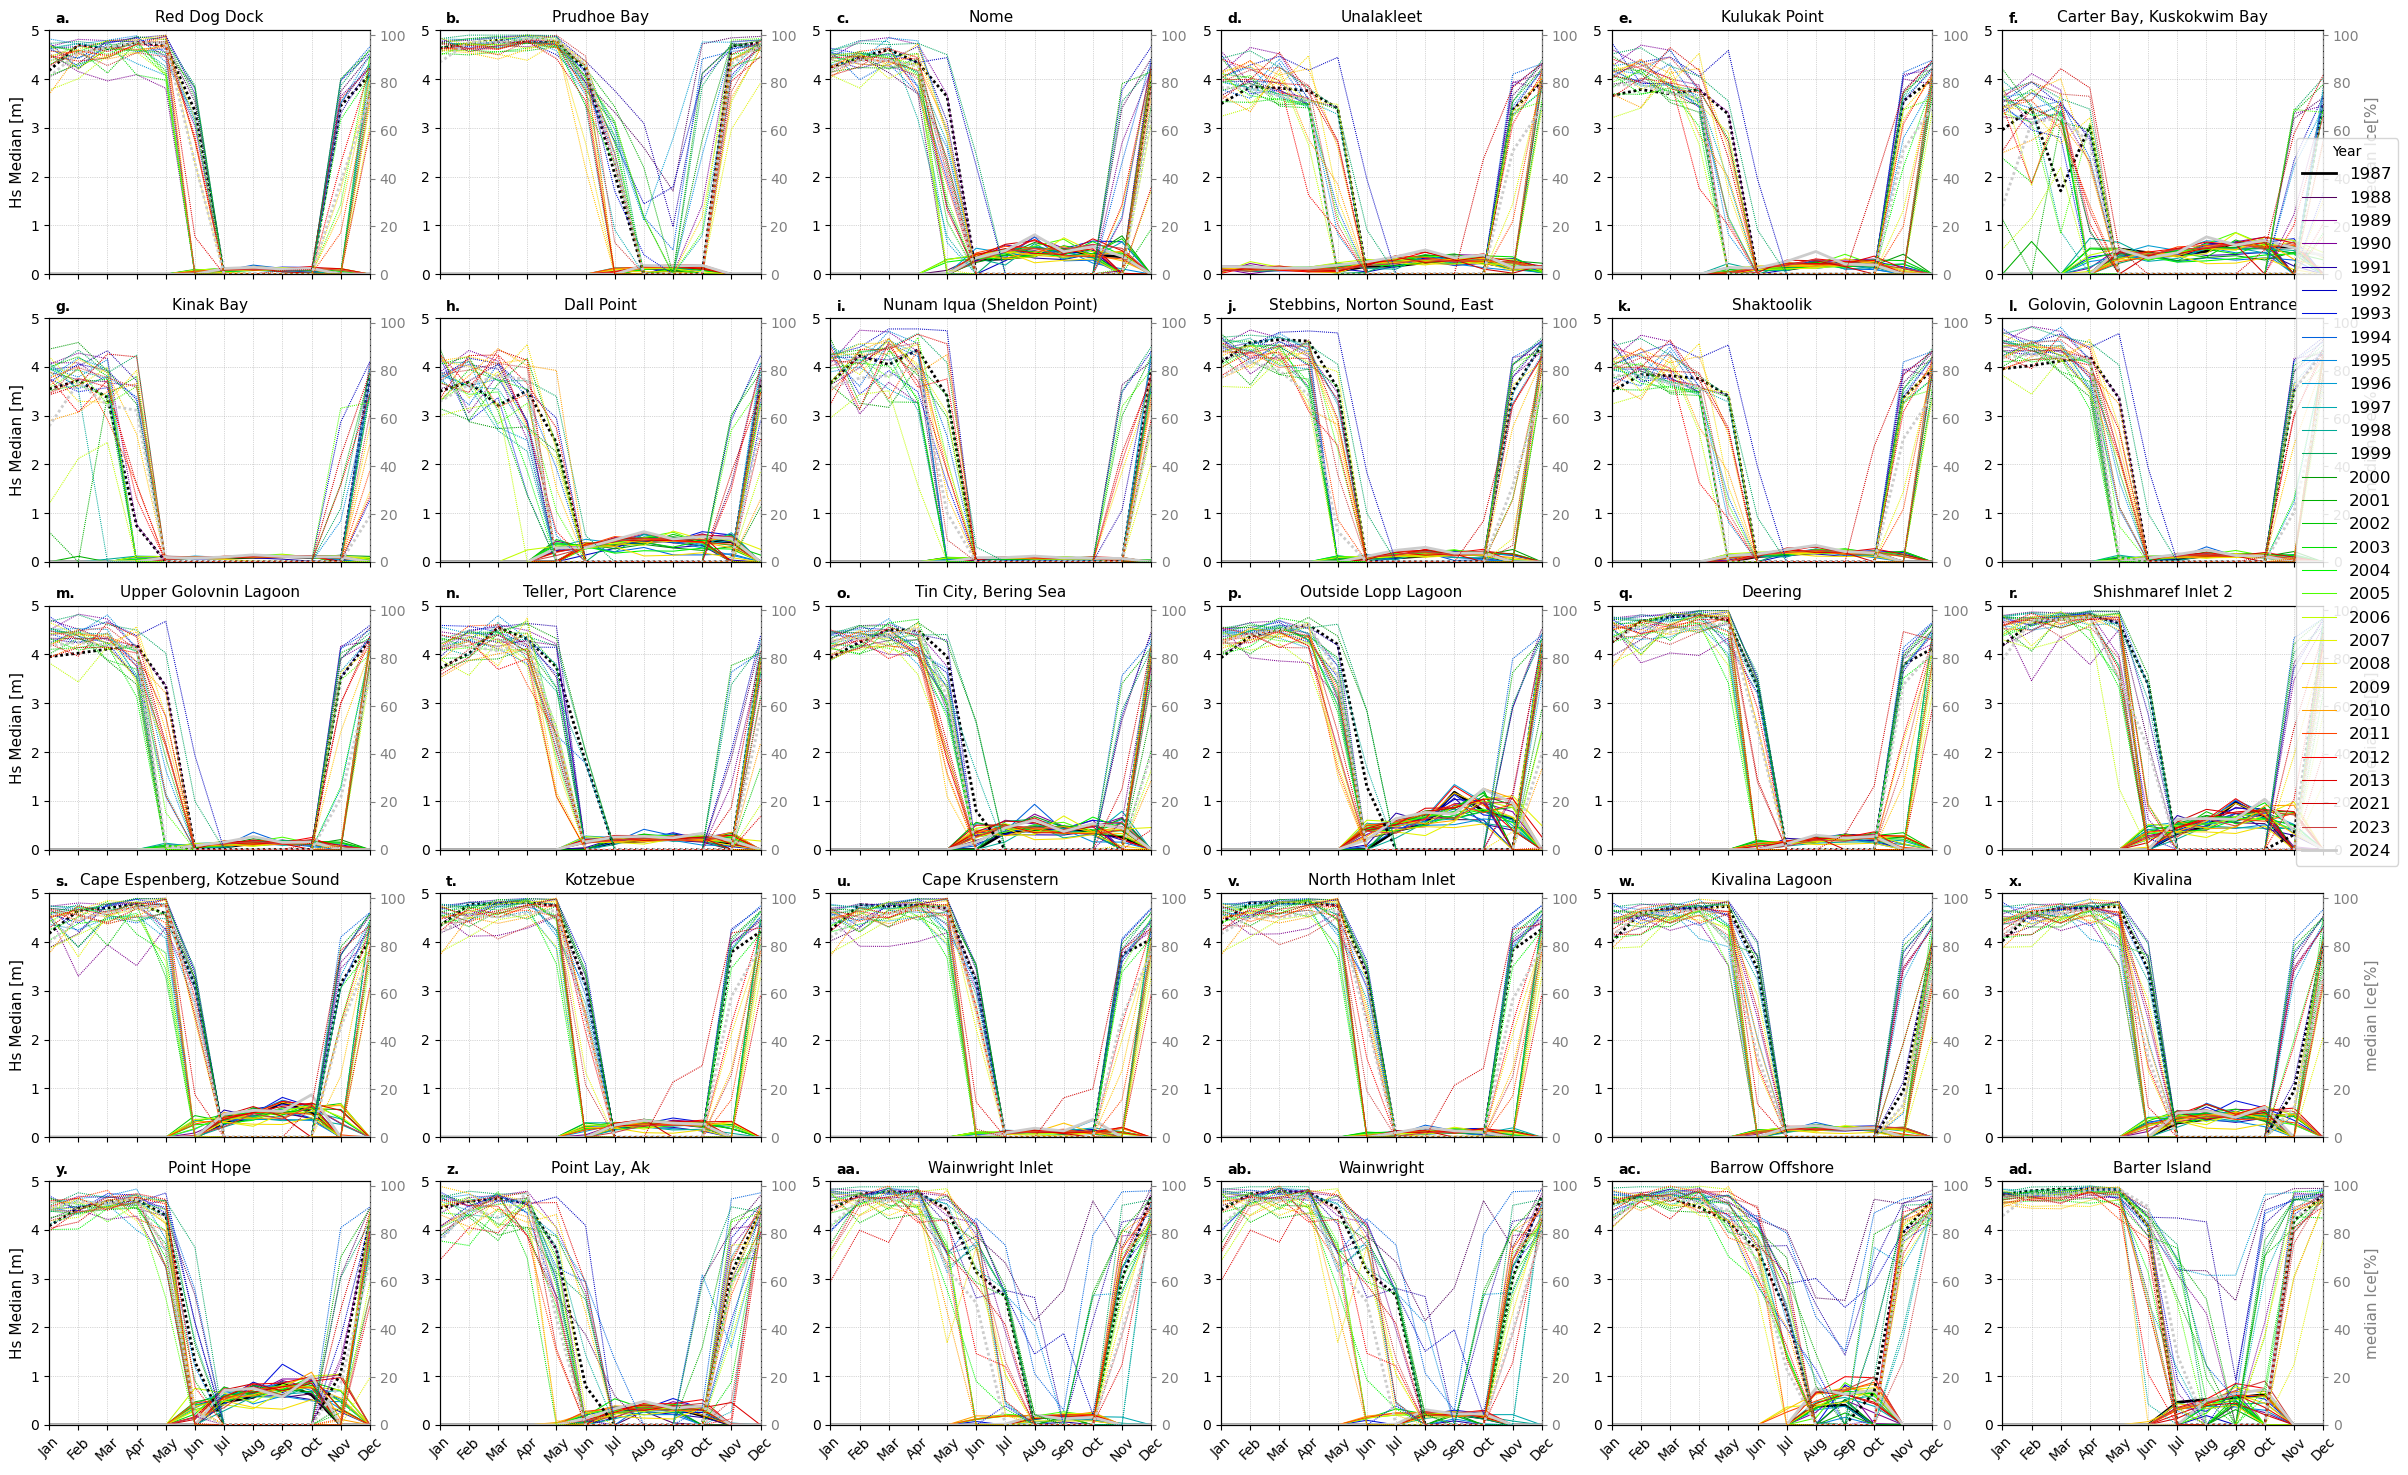

In [59]:

percentile_key = '50th'   # we're now plotting the 50th‐percentile
percentile_key2 = '50th'   # we're now plotting the 50th‐percentile
# monthly_data[comm][yr][m]['zeta_percentiles']['50th'], etc.

# exact community order & spelling
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]

# subplot labels
# letters for subplot labels
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']

# build grid
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True)
axes = axes.flatten()

# year color map
cmap   = mpl.cm.get_cmap("nipy_spectral", len(years))
colors = {yr: cmap(i) for i, yr in enumerate(years)}
min_y, max_y = years[0], years[-1]

for idx, comm in enumerate(comms_ordered):
    ax, ax2 = axes[idx], axes[idx].twinx()
    comm_dict = monthly_data.get(comm, {})

    for yr in years:
        year_dict = comm_dict.get(yr, {})

        # only integer keys are real months
        months = sorted(k for k in year_dict.keys() if isinstance(k, int))

        # extract the 50th percentile for each month
        z50 = [year_dict[m]['hs_percentiles'].get(percentile_key, np.nan)
               for m in months]
        i50 = [year_dict[m]['iceaf_percentiles'].get(percentile_key2, np.nan)
               for m in months]

        lw = 2.0 if yr in (years[0], years[-1]) else 0.75

        if np.any(~np.isnan(z50)):
            ax.plot(months, z50, color=colors[yr], linewidth=lw, label=yr)
        if np.any(~np.isnan(i50)):
            ax2.plot(months, i50, linestyle=(0, (1,1)), color=colors[yr], linewidth=lw)

    # fixed y‑limits
    ax .set_ylim(0, 5)
    ax2.set_ylim(  0,102)

    # style right axis
    ax2.spines['right'].set_color('gray')
    ax2.spines['right'].set_linestyle('--')
    ax2.tick_params(axis='y', colors='gray')
    ax2.yaxis.label.set_color('gray')

    # formatting
    ax .set_title(comm.title(), fontsize=11)
    ax .set_xlim(1,12)
    ax .set_xticks(range(1,13))
    ax .set_xticklabels([calendar.month_abbr[m] for m in range(1,13)],
                        fontsize=10, rotation=45)
    ax .grid(True, linestyle=':', linewidth=0.5)

    # y‑labels
    if idx % ncols == 0:
        ax .set_ylabel("Hs Median [m]", fontsize=11)
    if idx % ncols == ncols-1:
        ax2.set_ylabel("median Ice[%]", fontsize=11)

    # subplot letter
    ax .text(0.02, 1.03, letters[idx],
             transform=ax.transAxes, fontsize=10, weight='bold')

# hide extras
for ax in axes[n:]:
    ax.axis('off')

# legend
h, l = axes[0].get_legend_handles_labels()
fig.legend(h, l, title="Year", loc="upper center",
           bbox_to_anchor=(.980,0.9), fontsize=12)
plt.savefig('/scratch/tmiesse/project/figures/50th_months_hs.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

/tmp/ipykernel_1684454/201994558.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = mpl.cm.get_cmap("nipy_spectral", len(years))


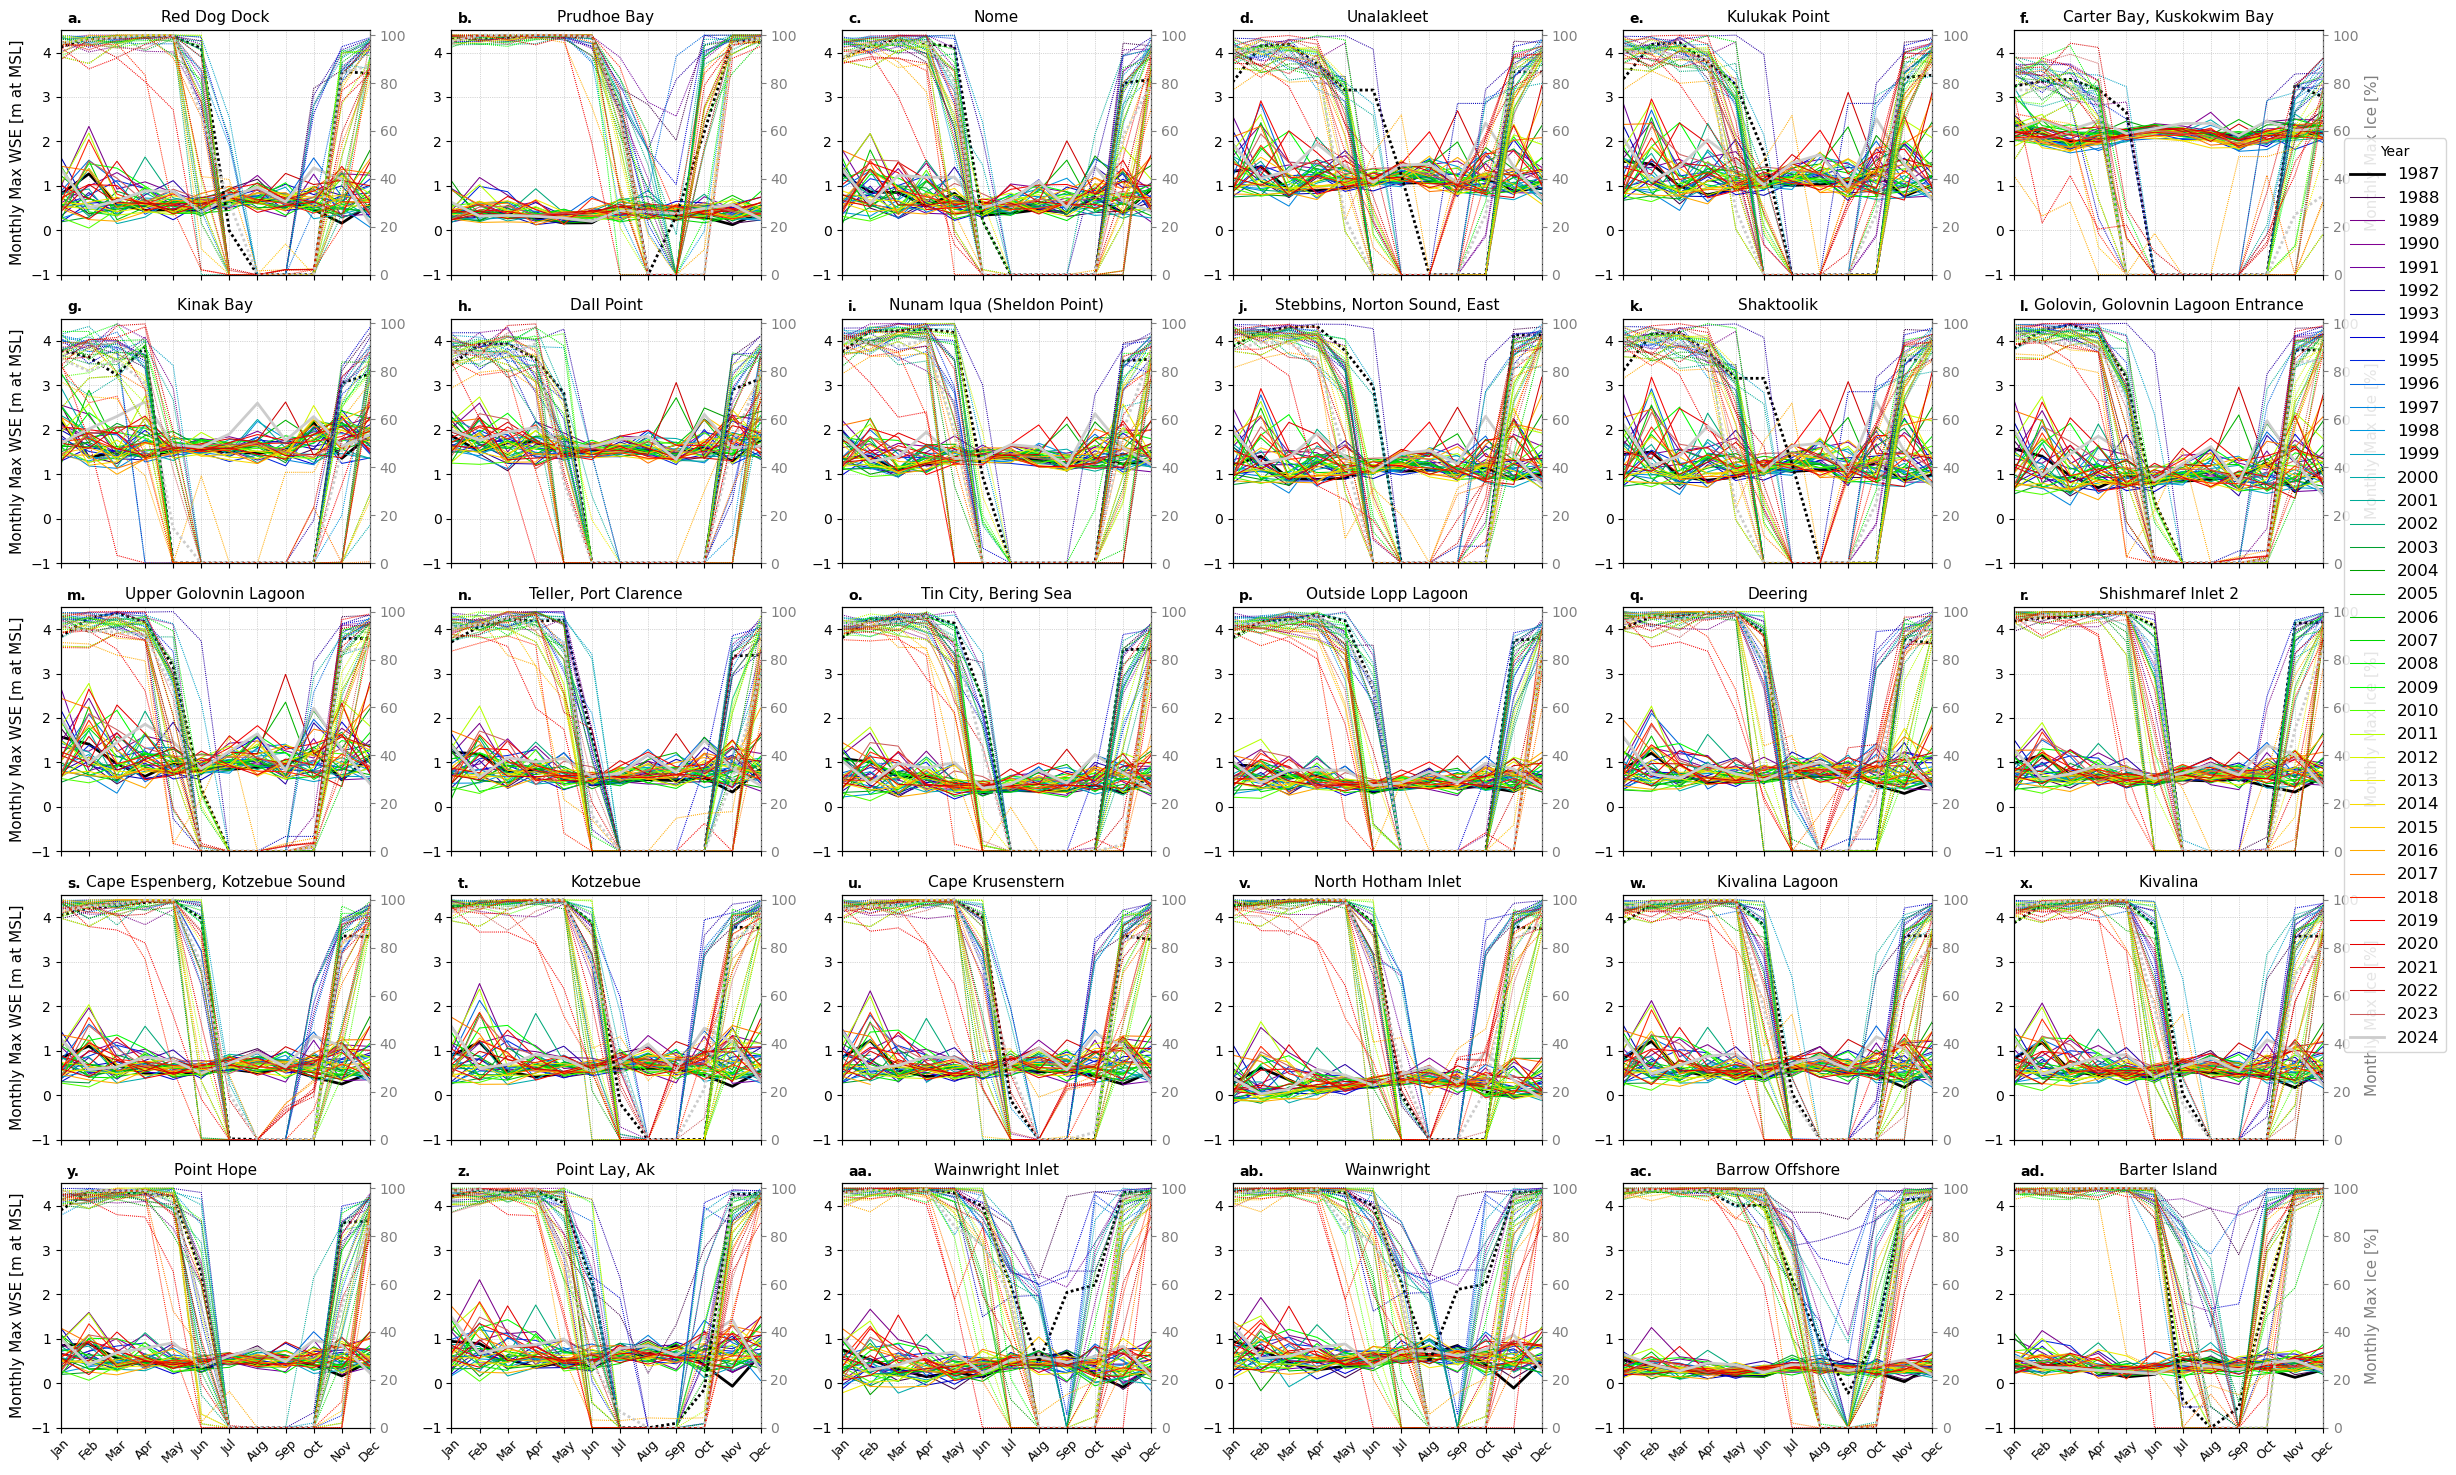

In [29]:

# monthly_data[comm][yr][month]['zeta_max'], ['iceaf_max']
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']

# build grid
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True)
axes = axes.flatten()

# color map
cmap   = mpl.cm.get_cmap("nipy_spectral", len(years))
colors = {yr: cmap(i) for i, yr in enumerate(years)}
min_y, max_y = years[0], years[-1]

for idx, comm in enumerate(comms_ordered):
    ax, ax2 = axes[idx], axes[idx].twinx()
    comm_dict = monthly_data.get(comm, {})

    for yr in years:
        yr_dict = comm_dict.get(yr, {})
        # only integer keys are months
        months = sorted(k for k in yr_dict.keys() if isinstance(k, int))
        zvals  = [yr_dict[m].get('zeta_max', np.nan)  for m in months]
        ivals  = [yr_dict[m].get('iceaf_max', np.nan) for m in months]
        lw = 2.0 if yr in (min_y, max_y) else 0.75

        if np.any(~np.isnan(zvals)):
            ax.plot(months, zvals, color=colors[yr], linewidth=lw, label=yr)
        if np.any(~np.isnan(ivals)):
            ax2.plot(months, ivals,linestyle=(0, (1,1)), color=colors[yr], linewidth=lw)

    # fixed y‑limits
    ax .set_ylim(-1, 4.5)
    ax2.set_ylim(  0,102)

    # style right axis
    ax2.spines['right'].set_color('gray')
    ax2.spines['right'].set_linestyle('--')
    ax2.tick_params(axis='y', colors='gray')
    ax2.yaxis.label.set_color('gray')

    # formatting
    ax .set_title(comm.title(), fontsize=11)
    ax .set_xlim(1,12)
    ax .set_xticks(range(1,13))
    ax .set_xticklabels([calendar.month_abbr[m] for m in range(1,13)],
                        fontsize=9, rotation=45)
    ax .grid(True, linestyle=':', linewidth=0.5)

    # y‑labels
    if idx % ncols == 0:
        ax.set_ylabel("Monthly Max WSE [m at MSL]", fontsize=11)
    if idx % ncols == ncols - 1:
        ax2.set_ylabel("Monthly Max Ice [%]", fontsize=11)

    # subplot letter
    ax.text(0.02, 1.03, letters[idx],
             transform=ax.transAxes, fontsize=10, weight='bold')

# hide extras
for a in axes[n:]:
    a.axis('off')

# legend
h, l = axes[0].get_legend_handles_labels()
fig.legend(h, l, title="Year", loc="upper center",
           bbox_to_anchor=(1.0,0.9), fontsize=12)
plt.savefig('/scratch/tmiesse/project/figures/max_months.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

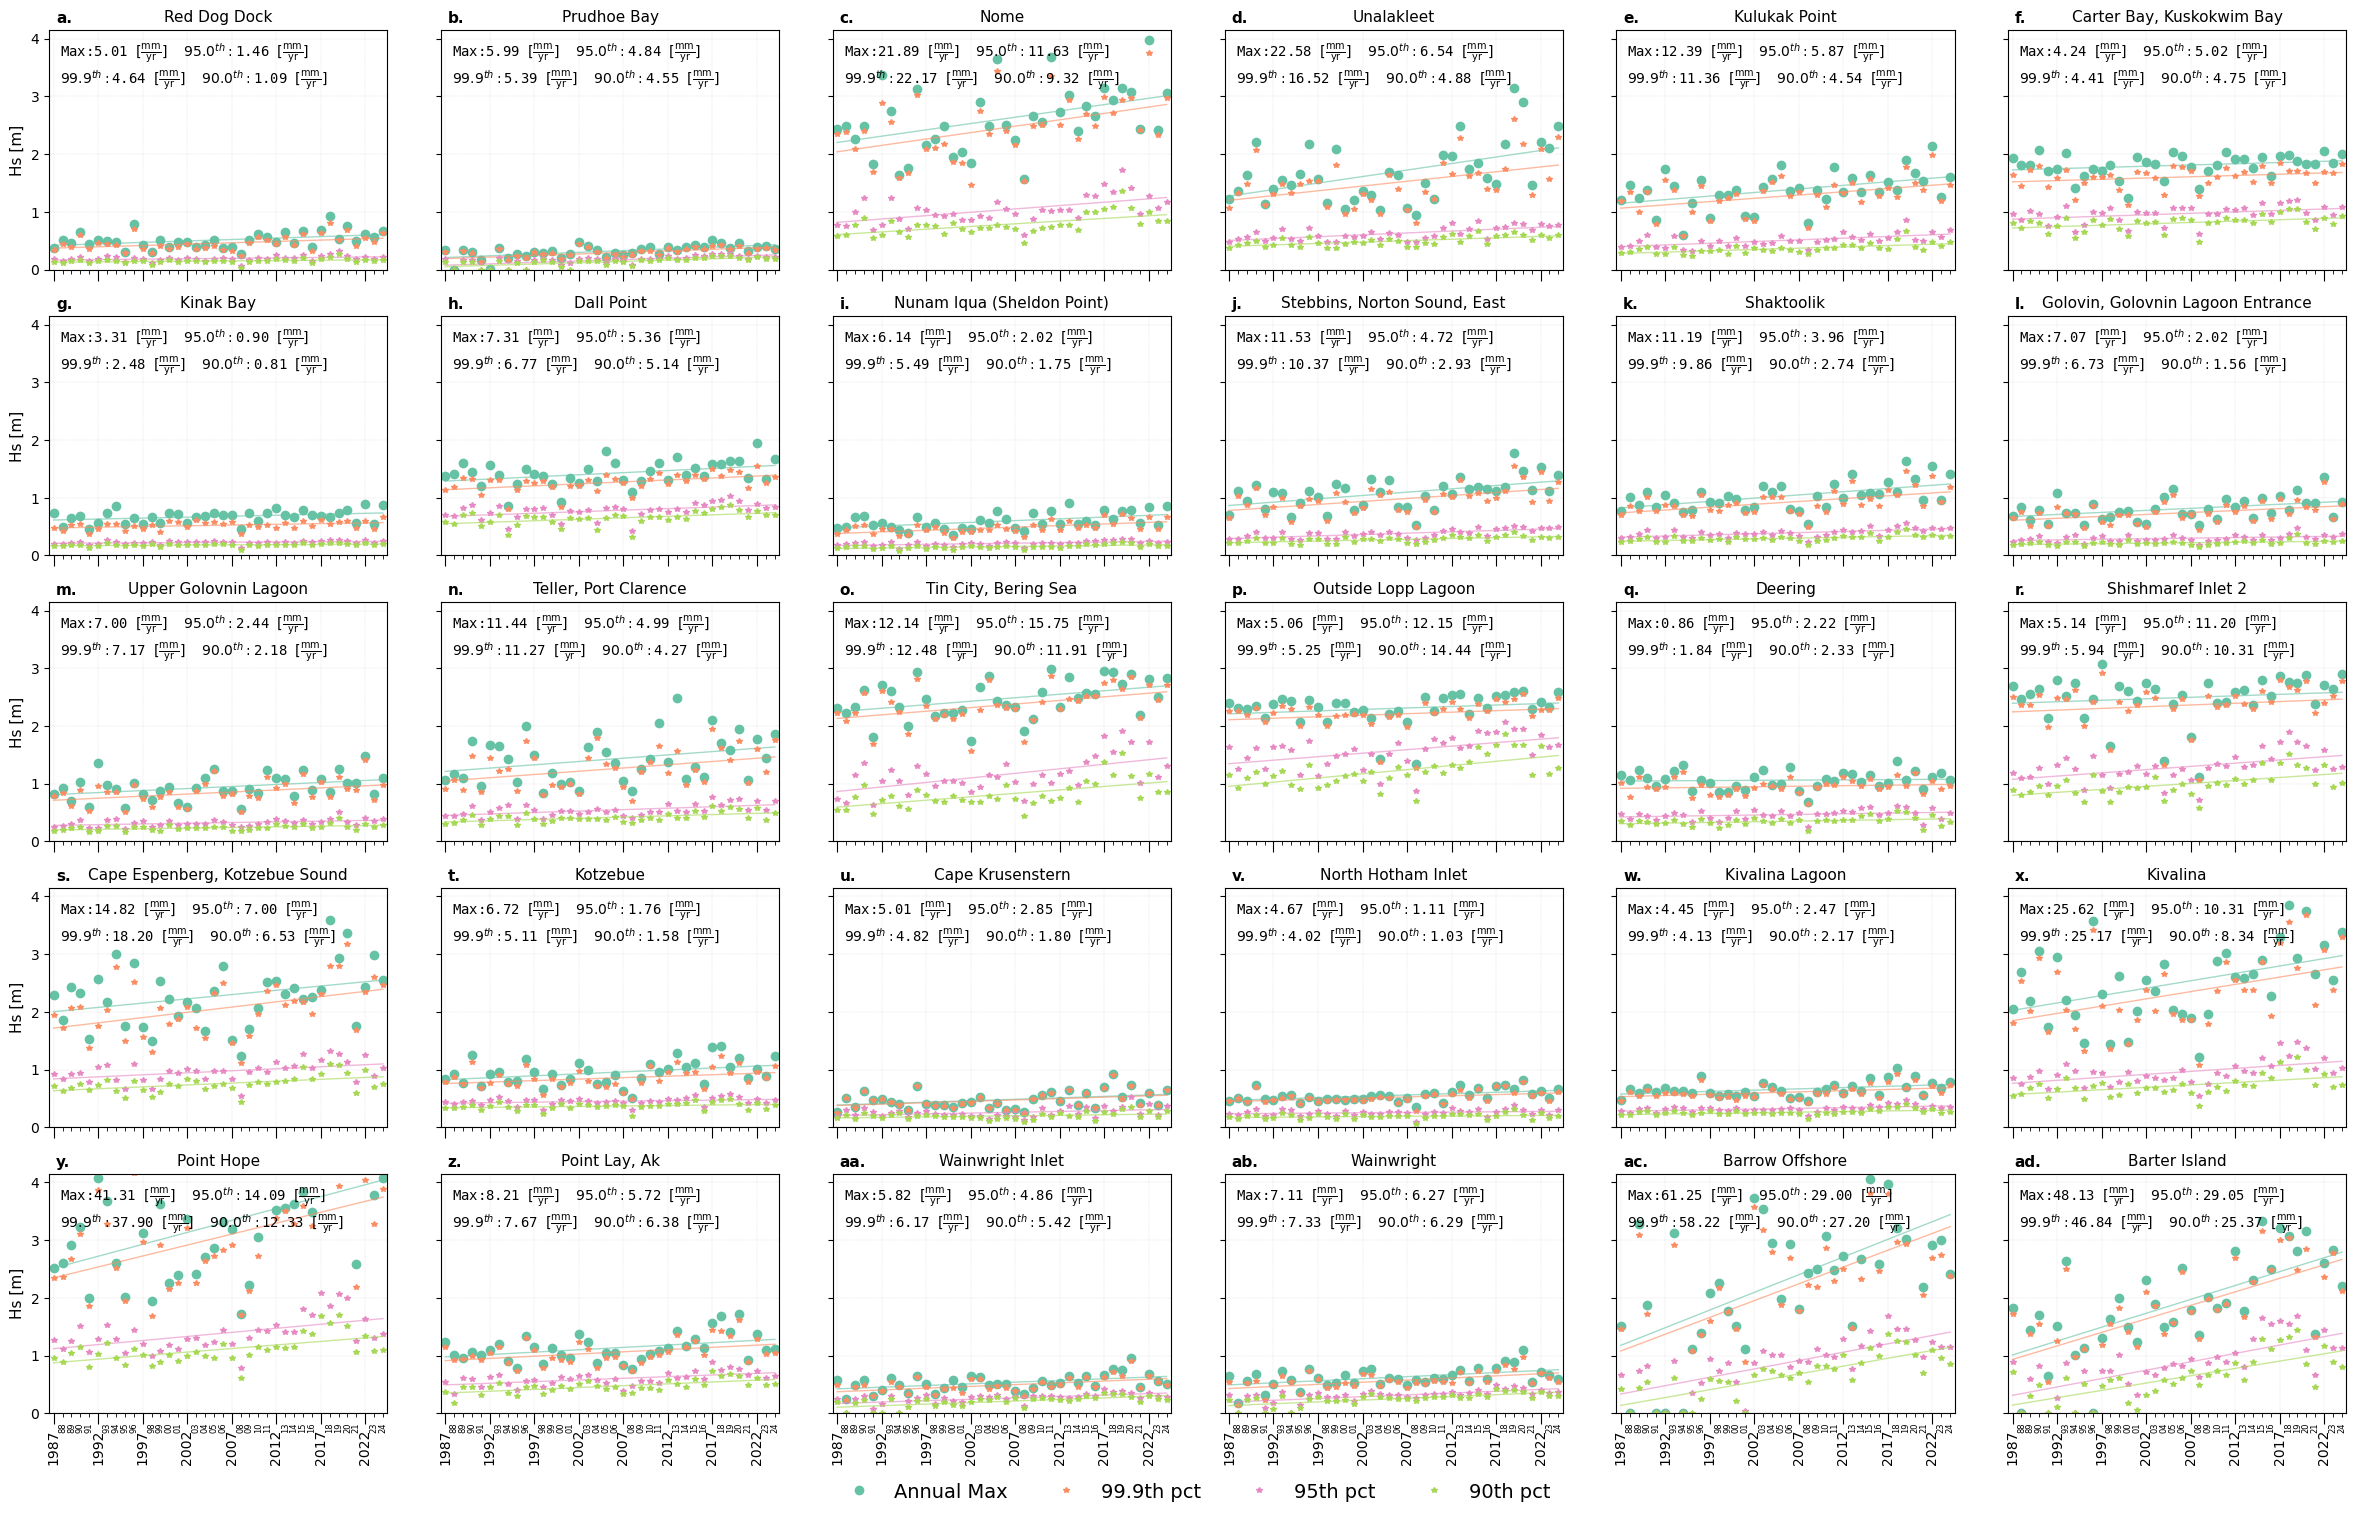

In [15]:
from matplotlib.ticker import FixedLocator, NullFormatter,FuncFormatter
years_int      = np.array([int(y) for y in years])

comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]

letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']

percentile_keys = ['99.9th','95th','90th']

annual_max = {
    comm: np.array([monthly_data[comm][yr]['yearly_max_hs'] for yr in years])
    for comm in comms_ordered
}
annual_pct = {
    comm: {
        pk: np.array([monthly_data[comm][yr]['hs_annual_percentiles'][pk] for yr in years])
        for pk in percentile_keys
    }
    for comm in comms_ordered
}

# ─── set up subplots ────────────────────────────────────────────────────────────
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True)
axes = axes.flatten()

cmap       = plt.get_cmap('Set2')
max_color  = cmap(0)
pct_colors = {'99.9th': cmap(1),'99th': cmap(2), '95th': cmap(3), '90th': cmap(4)}

# define major and minor tick locators


for idx, comm in enumerate(comms_ordered):
    ax = axes[idx]
    zmax = annual_max[comm]

    # plot annual max + trend
    ax.plot(years_int, zmax, 'o', color=max_color, lw=1.5, markersize=6, label='Annual Max')
    valid = ~np.isnan(zmax)
    if valid.sum() >= 2:
        m0, b0 = np.polyfit(years_int[valid], zmax[valid], 1)
        ax.plot(years_int, b0 + m0*years_int, '-', color=max_color, alpha=0.6, lw=1)

    # plot percentiles + trend, collect rates
    rates = []
    for pk in percentile_keys:
        arr = annual_pct[comm][pk]
        ax.plot(years_int, arr, '*', color=pct_colors[pk], lw=1, markersize=4, label=f'{pk} pct')
        vm = ~np.isnan(arr)
        if vm.sum() >= 2:
            m_p, b_p = np.polyfit(years_int[vm], arr[vm], 1)
            ax.plot(years_int, b_p + m_p*years_int, '-', color=pct_colors[pk], alpha=0.6, lw=1)
            rates.append((pk, m_p))

    # build two‐column lines
    lines = []
    if valid.sum() >= 2:
        lines.append((f"Max:", rf"{m0*1000:.2f} $[\frac{{\mathrm{{mm}}}}{{\mathrm{{yr}}}}]$"))
    for pk, m_p in rates:
        num = float(pk[:-2])
        sup = pk[-2:]
        lines.append((rf"$\mathrm{{{num}}}^{{{sup}}} \mathrm{{:}} $",
                      rf"{m_p*1000:.2f} $[\frac{{\mathrm{{mm}}}}{{\mathrm{{yr}}}}]$"))

    # split into two columns
    half = math.ceil(len(lines)/2)
    left, right = lines[:half], lines[half:]
    rows = []
    for i in range(half):
        l = left[i][0].ljust(4) + left[i][1].rjust(4)
        if i < len(right):
            r = right[i][0].ljust(4) + right[i][1].rjust(4)
            rows.append(l + "  " + r)
        else:
            rows.append(l)
    text = "\n".join(rows)

    # add anchored text with monospaced font
    at = AnchoredText(text,
                      loc='upper left',
                      prop=dict(family='monospace', size=10),
                      pad=0.3,
                      frameon=False)
    ax.add_artist(at)

    # formatting
    ax.set_title(comm.title(), fontsize=11)
    ax.set_xlim(years_int.min() - 0.5, years_int.max() + 0.5)
    major_ticks = years_int[::5]    # every 3rd year labeled
    minor_ticks = years_int         # all years shown as minor ticks
    # set major & minor ticks on x-axis
    ax.xaxis.set_major_locator(FixedLocator(major_ticks))
    ax.xaxis.set_minor_locator(FixedLocator(minor_ticks))
    ax.xaxis.set_major_formatter(plt.FixedFormatter([str(y) for y in major_ticks]))
    #ax.xaxis.set_minor_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: f"{int(x) % 100:02d}"))
    ax.tick_params(axis='x', which='major', rotation=90, labelsize=10, length=8)
    ax.tick_params(axis='x', which='minor', rotation=90, labelsize=6, length=3)

    ax.set_ylim(0, 4.15)
    ax.grid(True, linestyle=':', linewidth=0.25)

    if idx % ncols == 0:
        ax.set_ylabel("Hs [m]", fontsize=11)
    else:
        ax.tick_params(labelleft=False)

    ax.text(0.02, 1.03, letters[idx],
            transform=ax.transAxes, fontsize=11, weight='bold')

# hide unused axes
for ax in axes[n:]:
    ax.axis('off')

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center", ncol=4,
           bbox_to_anchor=(0.5, 0.01),
           fontsize=14, frameon=False)

plt.tight_layout(rect=[0, 0.0, 1, 0.99])
plt.savefig('/scratch/tmiesse/project/figures/annual_trends2_hs.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:103: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:103: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1723800/1401288571.py:90: SyntaxWarning: invalid escape sequence '\c'
  f"{lab} {m0*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau0:.2f}, p={p0:.3f})"
/tmp/ipykernel_1723800/1401288571.py:103: SyntaxWarning: invalid escape sequence '\c'
  f"{lab} {m_p*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau_p:.2f}, p={p_p:.3f})"


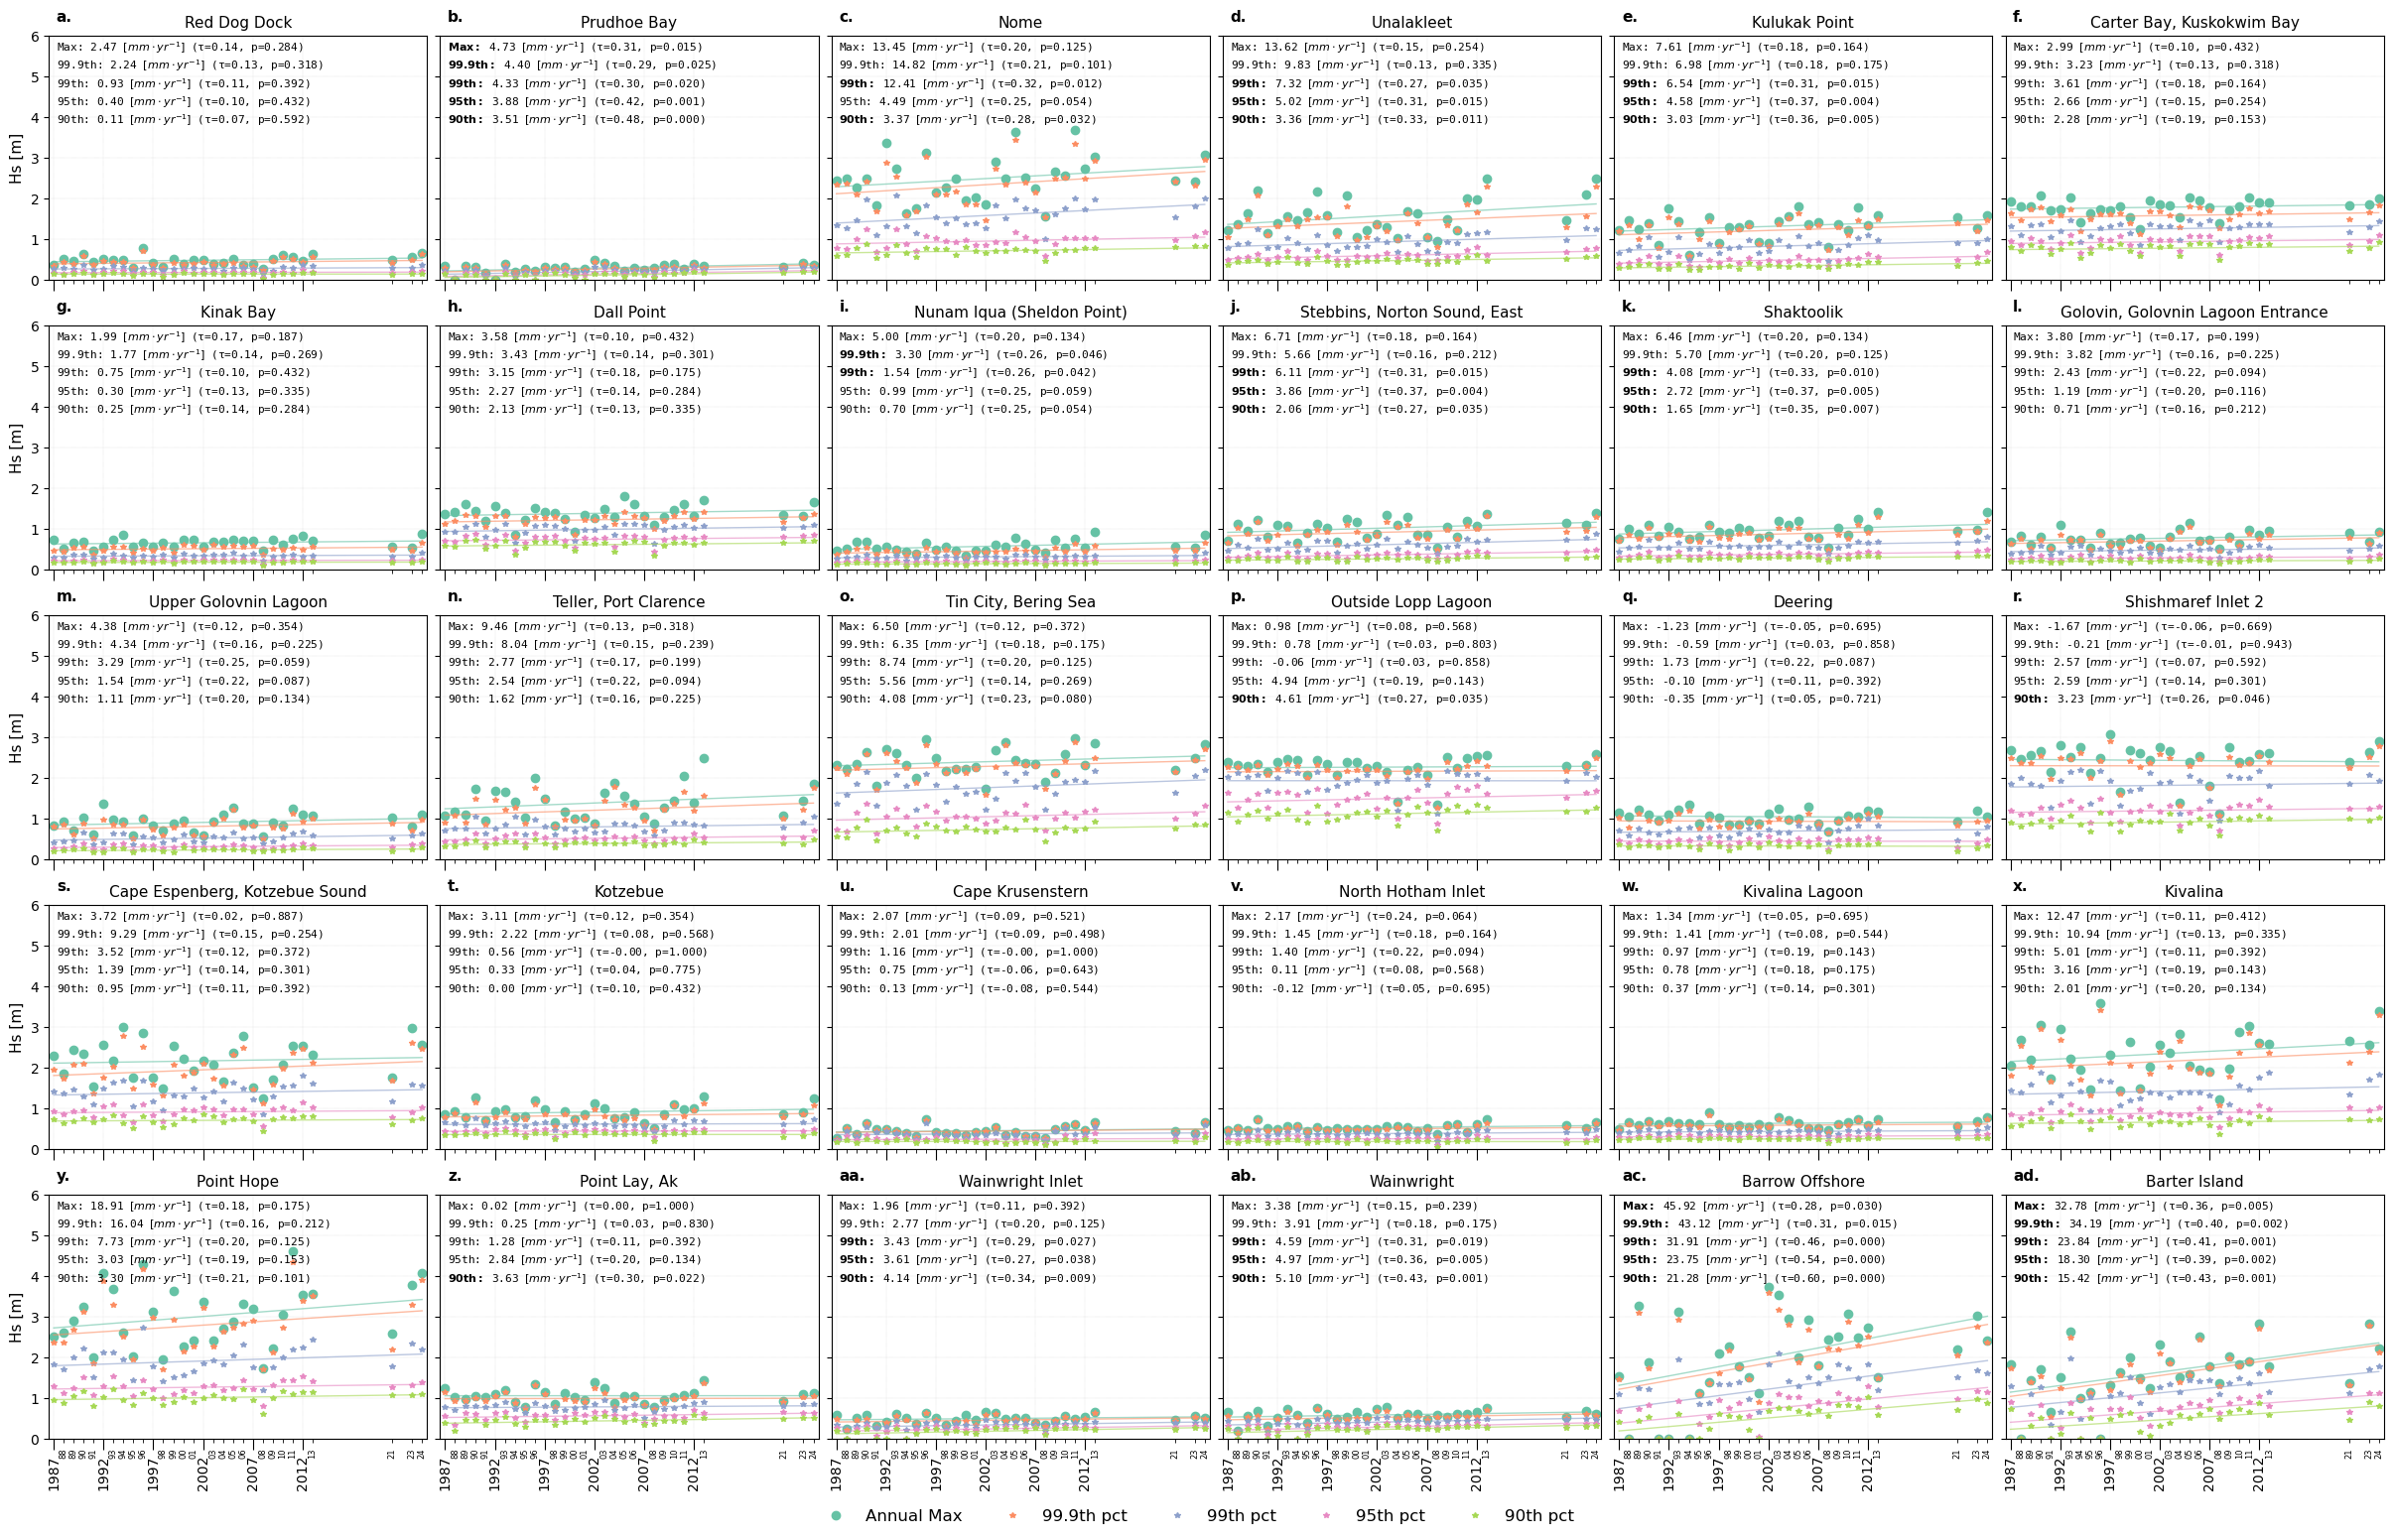

In [56]:
years_int = np.array([int(y) for y in years])

comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]

letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']

percentile_keys = ['99.9th','99th','95th','90th']

# ─── assume 'years' (list of year strings) and 'monthly_data' dict are already defined ────────────

annual_max = {
    comm: np.array([monthly_data[comm][yr]['yearly_max_hs'] for yr in years])
    for comm in comms_ordered
}
annual_pct = {
    comm: {
        pk: np.array([monthly_data[comm][yr]['hs_annual_percentiles'][pk] for yr in years])
        for pk in percentile_keys
    }
    for comm in comms_ordered
}

# ─── set up figure with constrained_layout ───────────────────────────────────────
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True,
                         constrained_layout=True)
axes = axes.flatten()

cmap       = plt.get_cmap('Set2')
max_color  = cmap(0)
pct_colors = {'99.9th': cmap(1),'99th': cmap(2), '95th': cmap(3), '90th': cmap(4)}

for idx, comm in enumerate(comms_ordered):
    ax = axes[idx]
    zmax = annual_max[comm]

    # plot annual max + linear fit
    ax.plot(years_int, zmax, 'o', color=max_color, lw=1.5, markersize=6, label='Annual Max')
    valid = ~np.isnan(zmax)
    if valid.sum() >= 2:
        # plot the OLS line
        m0, b0 = np.polyfit(years_int[valid], zmax[valid], 1)
        ax.plot(years_int, b0 + m0*years_int, '-', color=max_color, alpha=0.6, lw=1)

        # Mann–Kendall test
        mk0 = mk.original_test(zmax[valid])
        p0  = mk0.p       # p-value
        tau0 = mk0.Tau    # Kendall's τ

    # plot percentiles + trends
    rates = []
    for pk in percentile_keys:
        arr = annual_pct[comm][pk]
        ax.plot(years_int, arr, '*', color=pct_colors[pk], markersize=4, label=f'{pk} pct')
        vm = ~np.isnan(arr)
        if vm.sum() >= 2:
            m_p, b_p = np.polyfit(years_int[vm], arr[vm], 1)
            ax.plot(years_int, b_p + m_p*years_int, '-', color=pct_colors[pk], alpha=0.6, lw=1)

            mk_p = mk.original_test(arr[vm])
            p_p  = mk_p.p
            tau_p = mk_p.Tau
            rates.append((pk, m_p, p_p, tau_p))

    # build annotation text (with MK p-values & τ)
    lines = []
    if valid.sum() >= 2:
        # build the label, bold if significant
        lab = "Max:"
        if p0 < 0.05:
            lab = r"$\mathbf{Max:}$"
        lines.append(
            f"{lab} {m0*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau0:.2f}, p={p0:.3f})"
        )

    # percentiles
    for pk, m_p, p_p, tau_p in rates:
        # raw label (e.g. "99.9th:")
        raw = f"{pk}:"
        # if p<0.05, bold it
        if p_p < 0.05:
            lab = rf"$\mathbf{{{raw}}}$"
        else:
            lab = raw
        lines.append(
            f"{lab} {m_p*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau_p:.2f}, p={p_p:.3f})"
        )

    text = "\n".join(lines)
    ax.text(0.02, 0.985, text,
            transform=ax.transAxes,
            family='monospace', size=8,
            va='top', clip_on=False)

    # formatting (same as before)...
    ax.set_title(comm.title(), fontsize=11)
    ax.set_xlim(years_int.min() - 0.5, years_int.max() + 0.5)
    major = years_int[::5]; minor = years_int
    ax.xaxis.set_major_locator(FixedLocator(major))
    ax.xaxis.set_minor_locator(FixedLocator(minor))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: f"{int(x)%100:02d}"))
    ax.tick_params(axis='x', which='major', rotation=90, labelsize=10, length=8)
    ax.tick_params(axis='x', which='minor', rotation=90, labelsize=6, length=3)

    ax.set_ylim(0, 6)
    ax.grid(True, linestyle=':', linewidth=0.25)
    if idx % ncols == 0:
        ax.set_ylabel("Hs [m]", fontsize=11)
    else:
        ax.tick_params(labelleft=False)
    ax.text(0.02, 1.06, letters[idx], transform=ax.transAxes,
            fontsize=11, weight='bold', clip_on=False)

# turn off extra axes
for ax in axes[n:]:
    ax.axis('off')

# shared legend
h, l = axes[0].get_legend_handles_labels()
fig.legend(h, l, loc="upper center", ncol=5,
           bbox_to_anchor=(0.5, 0.0), fontsize=12, frameon=False)

# save & show
fig.savefig('/scratch/tmiesse/project/figures/annual_trends_mk2_hs.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [27]:
rows = []
for comm in comms_ordered:
    row = {'community': comm.title()}
    # include 'max' for annual_max plus each percentile
    metrics = ['max'] + percentile_keys
    for m in metrics:
        if m == 'max':
            arr = annual_max[comm]
        else:
            arr = annual_pct[comm][m]
        valid = ~np.isnan(arr)
        if valid.sum() >= 2:
            # compute slope (m/yr) and MK stats
            slope, _ = np.polyfit(years_int[valid], arr[valid], 1)
            res = mk.original_test(arr[valid])
            row[m]               = slope * 1000
            row[f"tau {m}"]      = res.Tau
            row[f"pvalue {m}"]   = res.p
        else:
            # not enough data
            row[m]             = np.nan
            row[f"tau {m}"]    = np.nan
            row[f"pvalue {m}"] = np.nan
    rows.append(row)

# make DataFrame and reorder columns
df_wide = pd.DataFrame(rows)
cols = (
    ['community'] +
    ['max'] +
    percentile_keys +
    ['tau max'] +
    [f"tau {pk}" for pk in percentile_keys] +
    ['pvalue max'] +
    [f"pvalue {pk}" for pk in percentile_keys]
)
df_wide = df_wide[cols]

# save to CSV
output_csv = '/scratch/tmiesse/project/all_trends_stats_wide.csv'
df_wide.to_csv(output_csv, index=False)
print(f"Saved wide-format trends to {output_csv}")

Saved wide-format trends to /scratch/tmiesse/project/all_trends_stats_wide.csv


In [7]:
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]
def decode_comms(raw):
    return [
        v.tobytes().decode('ascii').rstrip('\x00').strip().lower()
        for v in raw
    ]

def pct_label(p):
    s = f"{p*100:.3f}".rstrip('0').rstrip('.')
    return f"{s}th"

# ─── 1) Discover communities & read time coord per year ───────────────────────
with nc4.Dataset(str(root / f"{years[0]}.nc")) as ds0:
    raw_comms = ds0.variables['community'][:]    # byte strings
    comms     = decode_comms(raw_comms)
    lats      = ds0.variables['lat'][:]         # array of floats
    lons      = ds0.variables['lon'][:]

lat_map = {comms[i]: float(lats[i]) for i in range(len(comms))}
lon_map = {comms[i]: float(lons[i]) for i in range(len(comms))}

unique_comms = comms  # from first file

time_year = {}
for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        tvar = ds.variables['time']
        time_year[yr] = nc4.num2date(
            tvar[:], tvar.units, getattr(tvar, 'calendar', 'standard')
        )
years_int = np.array([int(y) for y in years])
rates     = {comm: {} for comm in comms_ordered}

for comm in comms_ordered:
    max_vals  = np.array([monthly_data[comm][yr]['yearly_max_zeta'] for yr in years], dtype=float)
    pct99_v   = np.array([monthly_data[comm][yr]['zeta_annual_percentiles']['99th'] for yr in years], dtype=float)
    pct95_v   = np.array([monthly_data[comm][yr]['zeta_annual_percentiles']['95th'] for yr in years], dtype=float)
    pct90_v   = np.array([monthly_data[comm][yr]['zeta_annual_percentiles']['90th'] for yr in years], dtype=float)

    for label, series in [('max', max_vals), ('99th', pct99_v),('95th', pct95_v), ('90th', pct90_v)]:
        mask = ~np.isnan(series)
        if mask.sum() >= 2:
            slope, _ = np.polyfit(years_int[mask], series[mask], 1)
            rates[comm][label] = slope * 1000  # in mm/yr
        else:
            rates[comm][label] = np.nan

    # attach coordinates
    rates[comm]['lat'] = lat_map[comm]
    rates[comm]['lon'] = lon_map[comm]

/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', n_classes)
/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', n_classes)
/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', n_classes)
/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarni

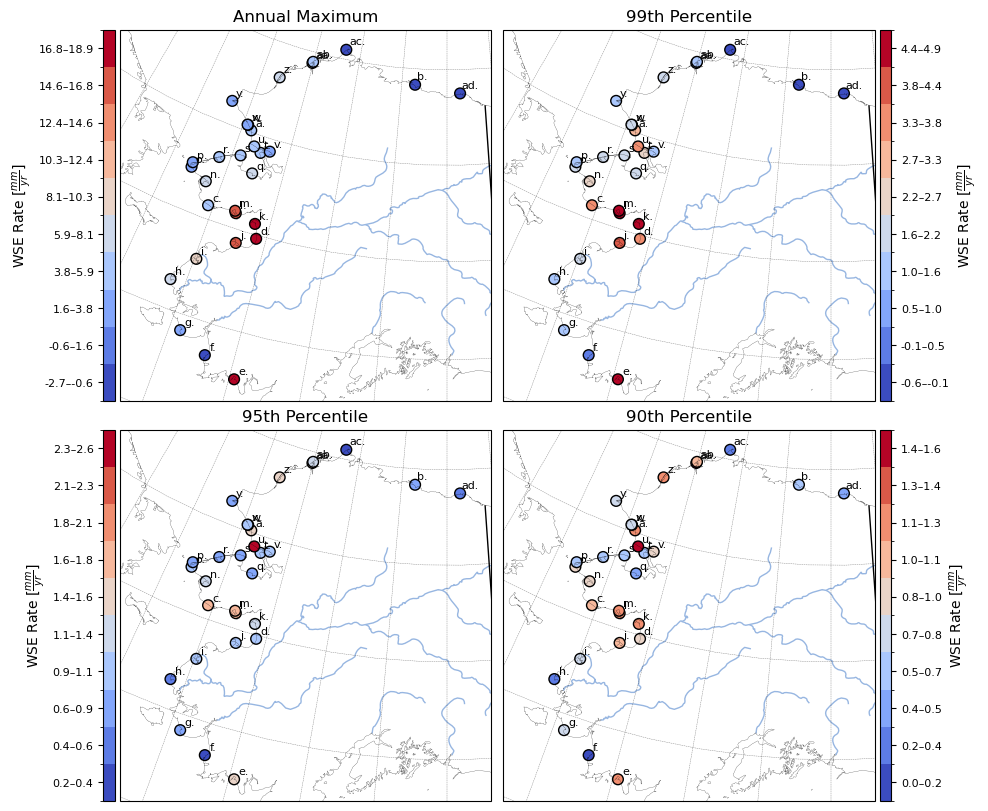

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
proj = ccrs.NorthPolarStereo(central_longitude=-145)
lat1, lat2 = 59, 71
lon1, lon2 = -168, -142

# ─── Metrics to plot ───────────────────────────────────────────────────────────
metrics = [
    ('max',  r'Annual Maximum'),
    ('99th', r'99th Percentile'),
    ('95th', r'95th Percentile'),
    ('90th', r'90th Percentile'),
]


n_classes = 10

# ─── (User must define these beforehand) ────────────────────────────────────────
# rates: dict, keys = community names, values = {'lon': float, 'lat': float, 'max':…, '99th':…, …}
# comms_ordered: list of community names, in the order you want to plot
# letters:      list of single‑letter labels, same length as comms_ordered

# ─── Create figure and 2×2 axes ────────────────────────────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(8, 8),
    subplot_kw={'projection': proj},
    constrained_layout=True
)
axes_flat = axes.flatten()

# ─── Loop over panels ─────────────────────────────────────────────────────────
for idx, (ax, (key, title)) in enumerate(zip(axes_flat, metrics)):
    # Base map
    ax.set_extent([lon1, lon2, lat1, lat2], crs=cart.crs.PlateCarree())
    ax.coastlines(resolution='10m', linewidth=0.15)
    ax.add_feature(cart.feature.RIVERS, linestyle='-')
    ax.add_feature(cart.feature.BORDERS.with_scale('50m'), linestyle='-')
    ax.gridlines(
        xlocs=np.arange(-190, -100, 5),
        ylocs=np.arange(-90,   90,   3.5),
        draw_labels=False,
        linewidth=0.3, color='black',
        alpha=0.5, y_inline=False,
        linestyle='--', zorder=20
    )

    # Extract, bin and normalize
    vals = np.array([rates[c][key] for c in comms_ordered], dtype=float)
    mask = ~np.isnan(vals)
    vmin, vmax = vals[mask].min(), vals[mask].max()
    boundaries = np.linspace(vmin, vmax, n_classes + 1)
    cmap = mpl.cm.get_cmap('coolwarm', n_classes)
    norm = mpl.colors.BoundaryNorm(boundaries, ncolors=n_classes, clip=True)

    # Scatter points
    lons = [rates[c]['lon'] for c in comms_ordered]
    lats = [rates[c]['lat'] for c in comms_ordered]
    sc = ax.scatter(
        lons, lats,
        c=vals, cmap=cmap, norm=norm,
        s=60, edgecolor='k',
        transform=cart.crs.PlateCarree()
    )

    # Label each point
    for j, comm in enumerate(comms_ordered):
        ax.text(
            rates[comm]['lon'] + 0.2,
            rates[comm]['lat'] + 0.2,
            letters[j],
            transform=cart.crs.PlateCarree(),
            fontsize=8, fontweight=None, color='k'
        )

    ax.set_title(title, fontsize=12)

    # Colorbar: left for left‑column (idx 0 & 2), right for right‑column (idx 1 & 3)
    divider = make_axes_locatable(ax)
    if idx % 2 == 0:
        cax = divider.append_axes('left',  size='3%', pad=0.05, axes_class=plt.Axes)
    else:
        cax = divider.append_axes('right', size='3%', pad=0.05, axes_class=plt.Axes)

    cbar = fig.colorbar(
        sc, cax=cax, orientation='vertical',
        ticks=(boundaries[:-1] + boundaries[1:]) / 2
    )
    # Put ticks, ticklabels, and label on correct side
    if idx % 2 == 0:
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.ax.yaxis.tick_left()
    else:
        cbar.ax.yaxis.set_ticks_position('right')
        cbar.ax.yaxis.set_label_position('right')
        cbar.ax.yaxis.tick_right()

    ticklabels = [
        f"{boundaries[i]:.1f}–{boundaries[i+1]:.1f}"
        for i in range(len(boundaries)-1)
    ]
    cbar.set_ticklabels(ticklabels, fontsize=8)
    cbar.set_label(r'WSE Rate $[\frac{mm}{yr}]$', fontsize=10)
plt.savefig('/scratch/tmiesse/project/figures/trend_maps.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
# Show plot
plt.show()